# Data and Analysis Plan: MLB Build a Team

## Team 4
- Tim Seymour (seymour.ti@northeastern.edu)

## Project Goal:
The goal of this project is to be able to predict how many wins any combination of players would have over a 162 game season. To do this, I build a classification model to estimate whether a team will win a given game. To generate a new data point, I will aggregate the statistics for a given lineup, rotation, and bullpen. For this new data point, I will use predict_proba to determine how likely that team is to win a given game - multiplying this value by 162 will give an estimate of how many wins that team would have assuming full health.
- My original idea was to build a regression model with team win totals over a season as the target, but this severely limits the size of the data set. My preference was to use data from as recently as possible because baseball has changed dramatically throughout its history, so including data from past eras could water down the significance of home run rate and strikeout rate in predicting the winner of a single game.

<a id='data'></a>

## Data
I will obtain statistics from FanGraphs including:

'HR', 'R', 'RBI', 'SB', 'BB%',
       'K%', 'ISO', 'BABIP_x', 'AVG', 'OBP', 'SLG', 'wOBA', 'xwOBA', 'wRC+',
       'BsR', 'Off', 'Def', 'WAR_x' (Hitter's war), 'SV',
       'K/9', 'BB/9', 'HR/9', 'BABIP_y', 'LOB%', 'GB%', 'HR/FB', 'vFA (pi)',
       'ERA', 'xERA', 'FIP', 'xFIP', 'WAR_y' (Pitcher's war)

There are considerations to be made about the inclusion of several of these statistics with many relying on luck which should not be projected over a season sample size. This will have a large effect on my feature selection process - stats used should be under team and player control. For example, BABIP or Batting Average on Balls in Play is a metric that will vary game to game and likely has more to do with luck than skill. While exit velocity and defensive alignment will have an impact, it is more practical to use a different statistic for generalization purposes. 

A stat like Saves also implies a win, so this would lead to overfitting. I will analyze the choices that I make in the feature selection process as I go. One other consideration is that it would be preferable to include at least one statistic representing each facet of the game - Def and BsR are the only defensive and baserunning advanced statistics that are kept on a game to game basis, so provided they have even a 2-3 game impact over a season they will be included in the model.

As for the inclusion of pitching and hitting statistics, I will make it a priority to include statistics that do not correlate strongly with each other (avoiding autocorrelation) to ensure the model has diverse features.

In [74]:
from bs4 import BeautifulSoup
import datetime
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import plotly
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from jupyter_dash import JupyterDash

In [2]:
pd.set_option('display.max_columns', None)

# Data Collection

Scraping team data from 2015 and later

In [3]:
def date_to_str(date):
    '''
    Args:
        date (datetime): datetime object for the day of the season

    Returns:
        str: string representation of the given date

    '''
    month = str(date.month)
    day = str(date.day)
    if date.day <= 9:
        day = str(0) + day
    if date.month <= 9:
        month = str(0) + month
    return str(date.year) + '-' + month + '-' + day

To include advanced stats on a game by game basis, I found FanGraphs to have the best combinations of metrics that would be helpful in predicting the winner of a single game.

Scraping process takes ~20 minutes

In [4]:
def collect_team_data():
  '''
    Scrapes FanGraphs data from each day between April 1, 2015 and today's date

    Returns:
        hit (pd.DataFrame) contains hitting stats with each record representing one game for a team
        pit (pd.DataFrame) contains pitching stats with each record representing one game for a team
'''
    # beginning of sample is 2015
    first_date = datetime.datetime(year = 2015, month = 4, day = 1)
    # When date reaches last date, date resets to first_date (plus one year)
    last_date = datetime.datetime(year = 2015, month = 10, day = 3)
    date = datetime.datetime(year = 2015, month = 4, day = 1)
    # collects team hitting stats for each day
    hit = pd.DataFrame()
    # collects team pitching stats for each day
    pit = pd.DataFrame()
    # sustainable way of changing year without change in code
    while (date < datetime.datetime.now()):
        date_str = date_to_str(date)
        print(date_str)
        # scrape hitting data
        hit_df = pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season={date.year}&month=1000&season1={date.year}&ind=0&team=0%2Cts&rost=0&age=0&filter=&players=0&startdate={date_str}&enddate={date_str}')
        # getting rid of the final row with non-numeric data
        hit_df = hit_df[16][:-1]
        hit_df[('temp', 'Date')] = date_str
        hit_df.columns = hit_df.columns.droplevel(0)
        if len(hit_df['#']) > 1:
            hit = hit.append(hit_df)
        # scrape pitching data
        pit_df = pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=8&season={date.year}&month=1000&season1={date.year}&ind=0&team=0%2Cts&rost=0&age=0&filter=&players=0&startdate={date_str}&enddate={date_str}')
        # getting rid of the final row with non-numeric data
        pit_df = pit_df[16][:-1]
        pit_df[('temp', 'Date')] = date_str
        pit_df.columns = pit_df.columns.droplevel(0)
        if len(pit_df['#']) > 1:
            pit = pit.append(pit_df)
        if (date < last_date):
            date += datetime.timedelta(days = 1)
        else:
            print(date.year)
            last_date = datetime.datetime(year = last_date.year + 1, month = last_date.month, day = last_date.day)
            first_date = datetime.datetime(year = first_date.year + 1, month = first_date.month, day = first_date.day)
            date = first_date
    return hit, pit

In [ ]:
hit, pit = collect_team_data()

In [ ]:
pit.drop(columns = ['G'], inplace = True)
# Joining hitting and pitching dataframes on team and date
all_stats = pd.merge(hit, pit, left_on = ['Team', 'Date'], right_on = ['Team', 'Date'], how = 'inner')
# Excludes data from days where team played a double header
all_stats = all_stats[all_stats.GS == '1']
all_stats.to_csv('daily_stats.csv') 
files.download('daily_stats.csv')

# Shortened Data Collection

In [4]:
all_stats = pd.read_csv("daily_stats.csv", encoding="utf-8")

# Cleaning

The data cleaning process consisted of changing the data type of each numerical column from a string to a float. I also dropped columns that did not have values for most game logs ('xwOBA', 'xERA'), columns that do not have anything to do with whether a game is won ('Team', 'G', 'Date', 'GS'), and columns that were disqualified as valid predictors ('PA', 'R', 'L', 'SV', 'IP', 'RBI')

In [6]:
# These columns have only null values for single games
all_stats.drop(columns = ['xwOBA', 'xERA'], inplace = True)

In [55]:
# turning every value in the dataframe into a float
def string_to_num(string):
    if(string == 'NA'):
        return 'NA'
    elif(type(string) == str):
        if('%' in string):
            string = string.replace('%', '')
    return float(string)

In [8]:
# applying the function to each column to ensure all data points are numerical
for col in all_stats.columns:
    if col not in ['Team', 'Date', 'GB']:
        all_stats[col] = all_stats[col].apply(string_to_num)

### Subjective decision made to exclude RBI
RBI is a statistic that is often outside of player control as it is highly dependent on how often runners are in scoring position for their at bats. It also could lead to overfitting as almost all runs result in an RBI and comparing RBIs to ERA would make for too obvious of a prediction. I have not excluded ERA to this point because, while it is a bit more within a player's control and is therefore more representative of their performance.

In [9]:
all_stats = all_stats.drop(columns = ['#_x', 'Team', 'G', 'PA', 'R',
       'Date', '#_y', 'L', 'SV', 'GS', 'IP', 'RBI', 'Unnamed: 0'])
# Only ~100 columns with null values
all_stats.dropna(inplace = True)

# Data Pre-Processing

The first step of preprocessing was to separate the data into X and y with 'W' (win) being the target variable. The next step is to scale X using StandardScaler to normalize the dataset. I then store the factors used in scaling each feature in a dictionary to be used in scaling aggregated player data for prediction. Finally, I split the data randomly into train, test, and validation sets with 15% used for validation.

In [10]:
X = all_stats.drop(columns = ['W'])
cols = X.columns
y = all_stats['W']

In [11]:
#Scaling each column to be 
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns = cols)

In [12]:
#Storing values used to scale each feature for manual normalization in later step
feat_names = np.append(scaler.get_feature_names_out()[:-1], 'WAR')
scales = pd.DataFrame({'Feature': feat_names, 'Unit Variance': scaler.scale_, 'Mean': scaler.mean_})
scales.set_index('Feature', inplace = True)

In [13]:
X

,HR,SB,BB%,K%,ISO,BABIP_x,AVG,OBP,SLG,wOBA,wRC+,BsR,Off,Def,WAR_x,K/9,BB/9,HR/9,BABIP_y,LOB%,GB%,HR/FB,vFA (pi),ERA,FIP,xFIP,WAR_y
0,-1.026693,4.213351,0.389798,0.632761,-0.733865,1.160386,0.413582,0.452521,-0.282579,-0.018308,0.013771,1.565807,0.088338,1.571914,0.271676,1.240666,-0.595483,-1.010722,-0.399011,1.421366,0.544532,-1.052587,-0.455563,-1.332203,-1.488352,-1.860683,1.337282
1,-1.026693,0.602534,-0.473674,1.579235,-0.631284,-0.417499,-1.118942,-1.278163,-0.967433,-1.183020,-1.176013,1.174978,-0.957510,-0.177217,-1.040534,0.892468,0.368980,-1.010722,1.196332,0.195205,-0.355636,-1.052587,-0.124491,-0.406834,-1.066900,-0.695837,0.396994
2,0.688349,1.806140,0.789944,-1.842635,0.963400,0.939482,1.719996,2.111094,1.482000,1.867418,2.138385,1.174978,2.180033,0.172609,2.239990,-1.893113,-0.595483,-0.189020,-1.281767,1.421366,1.084633,0.103016,1.034259,-1.023747,0.301634,0.279911,-0.543293
3,3.260912,0.602534,1.800838,-0.107431,2.492804,-1.048653,0.149787,0.825099,1.722625,1.490272,1.611481,0.393320,1.517663,0.172609,1.583886,0.196073,-0.595483,-1.010722,-1.611471,1.421366,0.760573,-1.052587,0.096223,-1.332203,-1.171079,-1.232877,1.337282
4,0.688349,-0.601071,-1.231844,-1.053906,1.159238,1.286617,1.707434,0.993360,1.605398,1.567920,1.509499,0.002491,1.482801,0.522435,1.583886,0.196073,-1.559945,-1.010722,0.483746,1.421366,-0.958749,-1.052587,-1.559134,-1.332203,-1.327348,-1.232877,0.867138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30434,-1.026693,-0.601071,0.979487,1.336550,-0.342189,0.276770,-0.716968,0.248204,-0.578732,-0.051585,-0.071213,-2.342484,-0.295140,-0.876870,-0.384429,-0.152125,1.815673,-0.189020,0.217855,0.097799,-0.292624,-0.317203,2.137830,0.210078,0.547875,1.013613,-0.543293
30435,-1.026693,-0.601071,2.264165,-0.738414,-0.883076,-1.290596,-1.407860,-0.184467,-1.275926,-0.661673,-0.581121,0.393320,-0.504309,-1.926349,-0.712481,0.544271,-0.113251,-0.189020,1.908919,-1.890415,-1.921929,-0.317203,0.041044,2.060816,-0.451297,-0.582378,-0.073150
30436,-1.026693,-0.601071,-1.126543,-0.010357,-1.237450,-0.322826,-0.566228,-1.085865,-1.097000,-1.160835,-1.040038,-0.388338,-0.887787,-0.876870,-1.040534,0.196073,0.069996,0.838108,0.483746,-0.377768,0.886596,0.967698,1.144616,0.404406,0.571552,-0.536994,-1.013437
30437,-1.026693,-0.601071,-0.263071,-0.617071,-1.507893,-1.616692,-1.684217,-1.686797,-1.825043,-1.870755,-1.719914,-0.388338,-1.201541,0.522435,-1.368586,-0.500323,2.780136,-1.010722,-0.399011,-0.263173,-1.066769,-1.052587,-0.400384,-0.098378,0.287428,1.906158,-1.013437


In [14]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.15, random_state=100)
#Saving testing set for final model testing
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=0.25, random_state=100)

# Feature Selection

My approach to feature selection is to use recursive feature elimination with a logistic regression model to determine the optimal number of features. Once the results of each model is recorded, I plot the train and test accuracy against the number of features to evaluate for overfitting.

In [ ]:
# selects the X most important features to be used for the model
def feature_selection(x_train, x_test, y_train, num_feats, print_bool):
    '''
    Args:
          x_train (pd.DataFrame): training set
          x_test (pd.DataFrame): testing set
          y_train (pd.DataFrame): target variable
          num_feats (int): number of features to select
          print_bool (boolean): decides whether or not to print selected features

    Returns:
          X_train_selected (np.array) contains new training set with optimal features selected
          X_test_selected (np.array) contains new testing set with optimal features selected

  '''
    # instantiate
    select = RFE(DecisionTreeRegressor(random_state = 300), n_features_to_select = num_feats)
    
    # fit the RFE selector to the training data
    select.fit(x_train, y_train)
    
    # transform training and testing sets so only the selected features are retained
    X_train_selected = select.transform(x_train)
    X_test_selected = select.transform(x_test)
    
    if print_bool:
      # prints selected features/Sample Output
      selected_features = [feature for feature, status in zip(x_train, select.get_support()) if status == True]
      
      print('Selected features:')
        for feature in selected_features:
            print(feature)

    # returns selected features
    return X_train_selected, X_test_selected;

In [ ]:
def calc_metrics(y_pred, y_actual, test_or_train, print_bool):
    '''
    input empty string for test_or_train if not relevant
    otherwise put train or test with trailing space

    Args:
        y_pred (pd.DataFrame): values predicted by classifier
        y_actual (pd.DataFrame): actual values
        test_or_train (str): string that will precede metrics to distinguish training, testing measurements
        print_bool (boolean): decides whether or not to print selected features

    Returns:
        results (Dict) contains metrics in format to be added to DataFrame
    '''
    a = accuracy_score(y_actual, y_pred)
    f1 = f1_score(y_actual, y_pred)
    prec = precision_score(y_actual, y_pred)
    rec = recall_score(y_actual, y_pred)
    auc = metrics.roc_auc_score(y_actual, y_pred)
    results = {f'{test_or_train}Accuracy': a, f'{test_or_train}Error': 1-a, f'{test_or_train}Precision': prec, f'{test_or_train}Recall': rec,
          f'{test_or_train}F1 Score': f1, f'{test_or_train}AUC': auc}
    if(print_bool):
        print(f'{test_or_train}Error: {1 - a}')
        print(f'{test_or_train}Accuracy: {a}')
        print(f'{test_or_train}Precision: {prec}')
        print(f'{test_or_train}Recall: {rec}')
        print(f'{test_or_train}F1: {f1}')
        print(f'{test_or_train}AUC: {auc}')
    return results


Evaluating Logistic Regression Performance with different amounts of features

In [ ]:
#list of dictionaries to make a DataFrame
dicts = []
# Evaluating models with 1 - 15 features
for num_feat in range(1, 16, 1):
    train, test = feature_selection(X_train, X_test, y_train, num_feat, False)
    LR = LogisticRegression()
    LR = LR.fit(train, y_train)
    # Training predictions
    y_pred_tr = LR.predict(train)
    # Testing predictions
    y_pred_test = LR.predict(test)
    train_results = calc_metrics(y_pred_tr, y_train, 'Train ', False)
    test_results = calc_metrics(y_pred_test, y_test, 'Test ', False)
    train_results.update(test_results)
    train_results['Num Features'] = num_feat
    dicts.append(train_results)
df = pd.DataFrame(dicts)
#Repeating the process excluding result-oriented statistics (LOB%, BABIP)
#list of dictionaries to make a DataFrame
dicts = []
# Evaluating models with 1 - 15 features
for num_feat in range(1, 16, 1):
    train, test = feature_selection(X_train.drop(columns = ['LOB%', 'BABIP_x', 'BABIP_y']), X_test.drop(columns = ['LOB%', 'BABIP_x', 'BABIP_y']), y_train, num_feat, False)
    LR = LogisticRegression()
    LR = LR.fit(train, y_train)
    # Training predictions
    y_pred_tr = LR.predict(train)
    # Testing predictions
    y_pred_test = LR.predict(test)
    train_results = calc_metrics(y_pred_tr, y_train, 'Train ', False)
    test_results = calc_metrics(y_pred_test, y_test, 'Test ', False)
    train_results.update(test_results)
    train_results['Num Features'] = num_feat
    dicts.append(train_results)
df_excluding = pd.DataFrame(dicts)
# Renaming Columns for graphing purposes
for col in df_excluding.columns:
    df_excluding.rename(columns = {col: col + ' excluding LOB%, BABIP'}, inplace = True)
df = pd.concat([df, df_excluding], axis = 1)

In [ ]:
df

,Train Accuracy,Train Error,Train Precision,Train Recall,Train F1 Score,Train AUC,Test Accuracy,Test Error,Test Precision,Test Recall,Test F1 Score,Test AUC,Num Features,Train Accuracy,Train Error,Train Precision,Train Recall,Train F1 Score,Train AUC,Test Accuracy,Test Error,Test Precision,Test Recall,Test F1 Score,Test AUC,Num Features
0,0.769120,0.230880,0.736476,0.844385,0.786748,0.768455,0.776936,0.223064,0.740549,0.847758,0.790536,0.777425,1,0.769120,0.230880,0.736476,0.844385,0.786748,0.768455,0.776936,0.223064,0.740549,0.847758,0.790536,0.777425,1
1,0.901154,0.098846,0.898753,0.906100,0.902412,0.901111,0.902149,0.097851,0.896647,0.907534,0.902058,0.902186,2,0.901154,0.098846,0.898753,0.906100,0.902412,0.901111,0.902149,0.097851,0.896647,0.907534,0.902058,0.902186,2
2,0.903010,0.096990,0.900497,0.908041,0.904253,0.902965,0.904313,0.095687,0.898555,0.910025,0.904254,0.904352,3,0.903010,0.096990,0.900497,0.908041,0.904253,0.902965,0.904313,0.095687,0.898555,0.910025,0.904254,0.904352,3
3,0.905844,0.094156,0.903897,0.910085,0.906980,0.905807,0.905086,0.094914,0.901670,0.907846,0.904747,0.905105,4,0.903886,0.096114,0.901561,0.908654,0.905094,0.903844,0.904004,0.095996,0.898248,0.909714,0.903944,0.904043,4
4,0.906978,0.093022,0.906167,0.909778,0.907969,0.906953,0.908177,0.091823,0.903763,0.912204,0.907964,0.908205,5,0.903989,0.096011,0.902070,0.908246,0.905147,0.903951,0.905086,0.094914,0.899446,0.910648,0.905012,0.905124,5
5,0.911255,0.088745,0.911354,0.912844,0.912098,0.911241,0.910032,0.089968,0.908385,0.910648,0.909515,0.910037,6,0.903886,0.096114,0.901806,0.908348,0.905065,0.903846,0.905395,0.094605,0.900493,0.910025,0.905234,0.905427,6
6,0.910946,0.089054,0.911299,0.912231,0.911765,0.910935,0.910342,0.089658,0.908189,0.911582,0.909882,0.910350,7,0.903525,0.096475,0.901410,0.908041,0.904713,0.903485,0.906477,0.093523,0.901447,0.911270,0.906332,0.906510,7
7,0.912183,0.087817,0.912020,0.914070,0.913043,0.912166,0.910651,0.089349,0.910025,0.910025,0.910025,0.910646,8,0.904040,0.095960,0.902243,0.908143,0.905184,0.904004,0.906322,0.093678,0.902160,0.910025,0.906076,0.906348,8
8,0.915687,0.084313,0.916931,0.915807,0.916368,0.915686,0.916680,0.083320,0.915449,0.916874,0.916161,0.916681,9,0.904453,0.095547,0.902568,0.908654,0.905601,0.904416,0.906941,0.093059,0.903276,0.910025,0.906638,0.906962,9
9,0.915327,0.084673,0.916616,0.915398,0.916006,0.915326,0.916680,0.083320,0.915449,0.916874,0.916161,0.916681,10,0.906308,0.093692,0.904395,0.910494,0.907434,0.906271,0.909105,0.090895,0.906444,0.910959,0.908696,0.909118,10


In [ ]:
px.line(df, x = 'Num Features', y = ['Train Accuracy', 'Test Accuracy', 'Train Accuracy excluding LOB%, BABIP', 'Test Accuracy excluding LOB%, BABIP'], title="Logistic Regression Accuracy with Different Numbers of Features",
            labels={ # replaces default labels by column name,
                'value': "Accuracy", 'variable': 'Accuracy Type'}, range_y = [.88, .93])

There is not much accuracy to be gained from using more than six or seven statistics 

### Feature selection favors result-oriented statistics, unsurprisingly
- LOB% signifies the percentage of baserunners that did not come around to score; this is a testament to the value of clutch hitting, although for this model this should not be factored in - timely hitting is more likely to be a result of luck
- BABIP_y is the percentage of balls put in play that result in hits which has an element of luck and is not as representative of the strength of a team or player as batting average itself

I have decided against using these metrics for the reasons I outline above and because as is seen in the graph, there is minimal gain in accuracy from their use.

In [ ]:
feature_selection(X_train.drop(columns = ['LOB%', 'BABIP_x', 'BABIP_y']), X_test.drop(columns = ['LOB%', 'BABIP_x', 'BABIP_y']), y_train, 10, True);

Selected features:
K%
OBP
SLG
wOBA
Off
GB%
vFA (pi)
ERA
FIP
xFIP


In [ ]:
X_train = X_train.drop(columns = ['LOB%', 'BABIP_x', 'BABIP_y'])
X_test = X_test.drop(columns = ['LOB%', 'BABIP_x', 'BABIP_y'])

The next means of feature selection used was to use to train random forest and adaboost classifiers to access the feature importance attribute. ERA was the most important feature as was expected because most runs are earned runs, so it is nearly one to one with runs given up.

In [ ]:
RFC = RandomForestClassifier() 
RFC.fit(X_train, y_train)

feature_importances = RFC.feature_importances_
feature_importances

array([0.0098843 , 0.00480071, 0.01496072, 0.01601637, 0.02304393,
       0.02717257, 0.03347352, 0.05560403, 0.06184924, 0.06524916,
       0.01062409, 0.06781879, 0.01114956, 0.06552806, 0.01311908,
       0.02292906, 0.04278479, 0.01532809, 0.01346109, 0.01505336,
       0.29026371, 0.04149879, 0.02259319, 0.0557938 ])

In [ ]:
ADA = AdaBoostClassifier() 
ADA.fit(X_train, y_train)

feature_importances_ada = ADA.feature_importances_
feature_importances_ada

array([0.  , 0.  , 0.  , 0.04, 0.04, 0.04, 0.04, 0.  , 0.14, 0.  , 0.02,
       0.1 , 0.02, 0.  , 0.  , 0.  , 0.18, 0.  , 0.02, 0.  , 0.24, 0.02,
       0.  , 0.1 ])

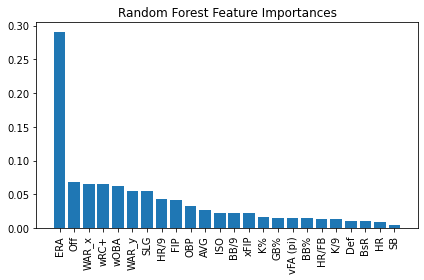

In [ ]:
sorted = np.argsort(feature_importances)[::-1]

plt.title('Random Forest Feature Importances')
plt.bar(range(X_train.shape[1]), feature_importances[sorted], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted], rotation=90)
plt.tight_layout()
plt.show()

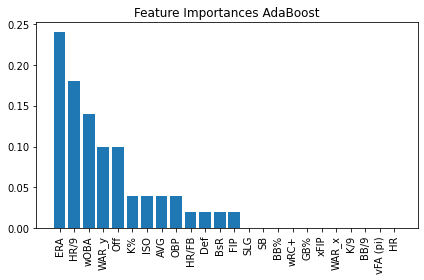

In [ ]:
sorted = np.argsort(feature_importances_ada)[::-1]

plt.title('Feature Importances AdaBoost')
plt.bar(range(X_train.shape[1]), feature_importances_ada[sorted], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted], rotation=90)
plt.tight_layout()
plt.show()

Here, I visualize each feature's correlation with every other feature, and then isolate each feauture's correlation with win percentage. Stats like WAR, FIP, and HR/9 stood out as statistics that could be best predictive of winning.

In [ ]:
corr_to_win = all_stats.corr()[['W']].sort_values('W', ascending = False)

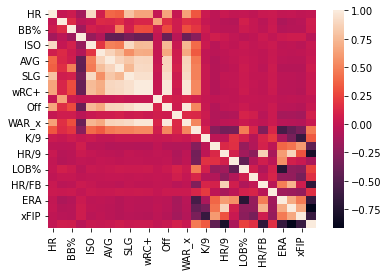

In [ ]:
# Interesting to note how offensive statistics have higher correlations with one another than pitching statistics
sns.heatmap(all_stats.corr())

In [ ]:
corr_to_win

,W
W,1.000000
wOBA,0.525073
wRC+,0.523888
WAR_x,0.519281
Off,0.518843
SLG,0.497097
OBP,0.493269
LOB%,0.472807
AVG,0.467611
WAR_y,0.463539


In [ ]:
fig = px.scatter(corr_to_win)
# make y-axis invisible in plot
fig.update_yaxes(title = 'Correlation to W-L%', visible = True, showticklabels = True)
fig.update_xaxes(title = 'Statistic', visible = True, showticklabels = True)

fig

ERA is dominant in terms of AdaBoost and Random Forest feature importance, although it is not regarded as the best measurement of inidividual pitching performance because it is known to be dependent on the quality of the pitcher's defense. For the purposes of my investigation, I would like to be able to assume a pitcher's defense will be whatever the inputted lineup will offer them, so despite this stat's effectiveness in win prediction, my next step is to look into the tradeoff of using FIP or pitching WAR in its place.

## Deciding which pitching statistics to use with Logistic Regression as a baseline model
FIP, ERA, and WAR_y have many common factors in their calculations, so I have decided to choose only one of the three so as to have diverse features that will not contradict each other in prediction
- Note: Pitching WAR is calculated using the following formula: 
  
  WAR = [[([(League “FIP” – “FIP”) / Pitcher Specific Runs Per Win] + Replacement Level) * (IP/9)] * Leverage Multiplier for Relievers] + League Correction

In [ ]:
X_train = X_train[['wRC+', 'HR/9', 'BsR', 'FIP', 'WAR_y', 'ERA', 'Def', 'SLG']]
X_test = X_test[['wRC+', 'HR/9', 'BsR', 'FIP', 'WAR_y', 'ERA', 'Def', 'SLG']]

In [ ]:
list(pitch_stats[0].values())

[['FIP', 'WAR_y']]

In [ ]:
dicts = []
pitch_stats = [{'ERA': ['FIP', 'WAR_y']}, {'WAR_y': ['FIP', 'ERA']}, {'FIP': ['ERA', 'WAR_y']}]
for drop_stats in pitch_stats:
    drop = list(drop_stats.values())
    drop = drop[0]
    stat = list(drop_stats.keys())
    stat = stat[0]
    xt = X_train.drop(columns = drop)
    xte = X_test.drop(columns = drop)
    LR = LogisticRegression()
    LR = LR.fit(xt, y_train)
    # Training predictions
    y_pred_tr = LR.predict(xt)
    # Testing predictions
    y_pred_test = LR.predict(xte)
    train_results = calc_metrics(y_pred_tr, y_train, 'Train ', False)
    test_results = calc_metrics(y_pred_test, y_test, 'Test ', False)
    train_results.update(test_results)
    train_results['Feature Used'] = stat
    dicts.append(train_results)
df = pd.DataFrame(dicts)

In [ ]:
df

,Train Accuracy,Train Error,Train Precision,Train Recall,Train F1 Score,Train AUC,Test Accuracy,Test Error,Test Precision,Test Recall,Test F1 Score,Test AUC,Feature Used
0,0.901361,0.098639,0.900336,0.904567,0.902446,0.901332,0.902149,0.097851,0.896891,0.907223,0.902028,0.902184,ERA
1,0.833539,0.166461,0.832606,0.838561,0.835573,0.833495,0.833668,0.166332,0.825610,0.843088,0.834258,0.833733,WAR_y
2,0.814832,0.185168,0.814034,0.820272,0.817141,0.814784,0.812954,0.187046,0.805742,0.821295,0.813444,0.813012,FIP


In [ ]:
px.bar(df, x = 'Feature Used', y = df.drop(columns = ['Feature Used', 'Test Error', 'Train Error']).columns, title="Logistic Regression Accuracy with Different Pitching Stats",
            labels={ # replaces default labels by column name,
                'value': "Accuracy", 'variable': 'Accuracy Type'}, barmode = 'group', range_y = [.77, .92])

Despite the ERA model's better performance across the board, I will use the WAR model because it is a better representation of a single pitcher's performance rather than the defense and pitching combined of a team. FIP is part of the calculation of WAR, so the WAR model is the obvious choice considering it is a better indicator of team success (which is expected as it is normalized for competition)

# Finalizing Training and Testing Sets

In [15]:
X_train = X_train[['wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG']]
X_test = X_test[['wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG']]
X_tr = X_tr[['wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG']]
X_te = X_te[['wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG']]
X = X[['wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG']]

<a id='visualization_2'></a>

# VISUALIZATION

In [ ]:
import plotly.express as px

px.scatter(team_data, x='BsR', y='W-L%', hover_data = ['Team'], color = 'Season')

In [ ]:
px.scatter(team_data, 'wRC+', 'W-L%', hover_data = ['Team'], color = 'Season')

In [ ]:
px.scatter(team_data, 'FIP', 'W-L%', hover_data = ['Team'], color = 'Season')

In [ ]:
px.scatter(team_data, 'WAR_y', 'W-L%', hover_data = ['Team'], color = 'Season', log_y=True)

In [ ]:
px.scatter(team_data, 'Def_x', 'W-L%', hover_data = ['Team'], color = 'Season', log_y=True)

# Tuning Models

To tune the models, I build a function that will graph model performance (train and test accuracy) for different hyperparameter values, and I will run GridSearch before deciding which values will perform the best.

## Graphing hyperparameter tuning function

In [ ]:
import matplotlib.pyplot as plt

def graph_hyper(model, val_list, val_name, arguments):
  '''
  Args:
    model: Sklearn object with global variable representing hyperparameter value
    val_list: values for hyperparameter to choose between
    val_name: hyperparameter name for naming axes, titling

  Purpose:
    Graph the testing vs training accuracy for different values of hyperparameters
  '''

    values = {}
    metrics_output = []

    for threshold in val_list:
        arguments[val_name] = threshold
        clf = model(**arguments)
        clf = clf.fit(X_train, y_train)
        y_train_prediction = clf.predict(X_train)
        y_test_prediction = clf.predict(X_test)
        training_accuracy = accuracy_score(y_train, y_train_prediction)        
        testing_accuracy = accuracy_score(y_test, y_test_prediction)

        values = {val_name : threshold,
                  'Training Accuracy' : training_accuracy,
                  'Testing Accuracy' : testing_accuracy}
        metrics_output.append(values)

    return px.line(metrics_output, x= val_name, y = ['Training Accuracy', 'Testing Accuracy'], title=f'Accuracy for Various {val_name} Values', 
                 labels={'variable': 'Accuracy Type', 'value': 'Accuracy'})

## Tuning RandomForestClassifier

In [ ]:
graph_hyper(RandomForestClassifier, [10, 20, 30, 40, 50], 'n_estimators', {'n_estimators': 0, 'criterion': 'entropy', 'random_state': 100})

From this plot, it is clear there is not much accuracy to be gained from having more than 30 estimators:

- Testing Accuracy goes from .849 to .851 when using 30 and 40 estimators

In [ ]:
graph_hyper(RandomForestClassifier, range(1, 25, 1), 'max_depth', {'n_estimators': 30, 'max_depth': 0, 'criterion': 'entropy', 'random_state': 100})

From this plot, it is clear there is not much accuracy to be gained from having more than 6 as the max depth and the model clearly overfits after this threshold:

- Testing Accuracy goes from .851 to .861 when using 6 and 10 as the max depth and the gap between training and testing accuracy balloons from .0018 to .0252

### Using GridSearch to inform best hyperparameters based on graph output

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [20, 30, 40]
grid['max_depth'] = [6, 7, 8]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=rfc, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.853054 using {'max_depth': 8, 'n_estimators': 40}


To avoid overfitting, I will use a max depth of 6 and 30 for n_estimators

## Tuning AdaBoost hyperparameters

In [ ]:
graph_hyper(AdaBoostClassifier, [10, 20, 30, 50, 60, 70, 80, 90, 100], 'n_estimators', {'n_estimators': 0})

Testing accuracy actually exceeds training accuracy until 60 estimators were used. 80 estimators had practically the same training as testing accuracy and .004 better testing accuracy than the model with 50 estimators

In [ ]:
graph_hyper(AdaBoostClassifier, [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.75, 1.0], 'learning_rate', {'n_estimators': 50, 'learning_rate': 0})

Testing accuracy actually exceeds training accuracy for the model with a learning rate of 1 and it has the highest accuracy of any model, so a learning rate of 1 is the obvious choice

### Using GridSearch to inform best hyperparameters based on graph output

In [ ]:
ada = AdaBoostClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [60, 70, 80, 100]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=ada, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.855270 using {'learning_rate': 1.0, 'n_estimators': 100}


I will use a learning rate of 1 and 80 for n_estimators

## MLP Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive']}

mlp = MLPClassifier()
# define the grid search procedure
grid_search = GridSearchCV(estimator=mlp, param_grid=grid, n_jobs=-1, cv=3, scoring='accuracy', verbose = 10)
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best: 0.837044 using {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

## Gradient Booster Hyperparameter tuning

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8604111918379966

## Comparing tuned model performances

With hyperparameter values set, this section collects metrics for each model using the final testing set to determine the best performing models.

In [ ]:
def print_metrics(y_pred, y_actual, test_or_train, print_bool):
    '''
    input empty string for test_or_train if not relevant
    otherwise put train or test with trailing space
    '''
    a = accuracy_score(y_actual, y_pred)
    f1 = f1_score(y_actual, y_pred)
    prec = precision_score(y_actual, y_pred)
    rec = recall_score(y_actual, y_pred)
    auc = metrics.roc_auc_score(y_actual, y_pred)

    if(print_bool):
        print(f'{test_or_train}Error: {1 - a}')
        print(f'{test_or_train}Accuracy: {a}')
        print(f'{test_or_train}Precision: {prec}')
        print(f'{test_or_train}Recall: {rec}')
        print(f'{test_or_train}F1: {f1}')
        print(f'{test_or_train}AUC: {auc}')
    return {f'{test_or_train}Accuracy': a, f'{test_or_train}Error': 1-a, f'{test_or_train}Precision': prec, f'{test_or_train}Recall': rec,
          f'{test_or_train}F1 Score': f1, f'{test_or_train}AUC': auc}

In [ ]:
for model in [GaussianNB(), LogisticRegression(), RandomForestClassifier(n_estimators = 30, max_depth = 6), AdaBoostClassifier(learning_rate = 1, n_estimators = 80),
              MLPClassifier({'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'solver': 'adam'})]:
    print(model)
    model = model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    print_metrics(y_pred, y_te, '', True)

In [ ]:
final_results = list()
for model in [GaussianNB(), LogisticRegression(), RandomForestClassifier(n_estimators = 30, max_depth = 8), AdaBoostClassifier(learning_rate = .3, n_estimators = 30),
              MLPClassifier(activation= 'relu', alpha=0.05, hidden_layer_sizes= (100,), learning_rate= 'constant', solver= 'adam')]:
    model.fit(X, y)
    #final y predictions
    y_pred_fin = model.predict(X_test)
    #final y train predictions
    y_pred_fin_tr = model.predict(X)
    #Train results
    tr = print_metrics(y_pred_fin_tr, y, 'Train ', False)
    #Test results
    te = print_metrics(y_pred_fin, y_test, 'Test ', False)
    te.update(tr)
    final_results.append(te)
final = pd.DataFrame(final_results)
  

In [ ]:
first_column = ['Naiver Bayes', 'Logistic Regression', 'Random Forest Classifier', 'AdaBoostClassifier', 'MLP Classifier']

final.insert(0, 'Model', first_column)
final

,Model,Test Accuracy,Test Error,Test Precision,Test Recall,Test F1 Score,Test AUC,Train Accuracy,Train Error,Train Precision,Train Recall,Train F1 Score,Train AUC
0,Naiver Bayes,0.729248,0.270752,0.723150,0.744152,0.733500,0.729227,0.734737,0.265263,0.727120,0.751104,0.738917,0.734744
1,Logistic Regression,0.737226,0.262774,0.729355,0.755566,0.742229,0.737200,0.739810,0.260190,0.730059,0.760614,0.745023,0.739820
2,Random Forest Classifier,0.736378,0.263622,0.717640,0.780653,0.747821,0.736315,0.750297,0.249703,0.730750,0.792278,0.760272,0.750317
3,AdaBoostClassifier,0.737736,0.262264,0.727636,0.761103,0.743993,0.737702,0.744280,0.255720,0.733009,0.768087,0.750138,0.744292
4,MLP Classifier,0.741131,0.258869,0.718195,0.794892,0.754600,0.741054,0.746619,0.253381,0.723674,0.797524,0.758806,0.746643


In [ ]:
px.bar(final, x = 'Model', y = ['Train Accuracy', 'Test Accuracy'], barmode = 'group', title='Accuracy for each Model', 
                 labels={'variable': 'Accuracy Type', 'value': 'Accuracy'}, range_y = [.72, .76])

Each model performs very similarly in terms of test accuracy. The MLP Classifier does achieve the best test accuracy and F1 score, indicating that it was the best performing model by a small margin.

# Scraping Player Data

This section includes code that was originally used in scraping data. I now have a seperate script entitled Automated_Data_Collection that refreshes the data in a local MySQL database. The scraping process is time consuming, so I took this step to allow for a better user experience in the app I have created using this model.

In [16]:
# beginning of sample is 2015
year = 2021
wrc = pd.DataFrame()
pitch = pd.DataFrame()
field = pd.DataFrame()
# sustainable way of changing year without change in code
while year < datetime.datetime.now().year + 1:
    for num in range(int(pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season={year}&month=0&season1={year}&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate=&page=1_50')[16].columns[0][0][-8:-6].strip())):
        # scrape hitting data
        if (num < 1):
            temp = pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season={year}&month=0&season1={year}&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate=&page={str(num + 1)}_50')[16][:-1]   
            temp.columns = temp.columns.droplevel(0)
            wrc_df = temp
        else:
            temp = (pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season={year}&month=0&season1={year}&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate=&page={str(num + 1)}_50')[16][:-1])
            temp.columns = temp.columns.droplevel(0)
            wrc_df = wrc_df.append(temp)
        # getting rid of the final row with non-numeric data above
    wrc_df['Season'] = year
    wrc = wrc.append(wrc_df)
    # scrape pitching data
    for num in range(int(pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=8&season={year}&month=0&season1={year}&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate={year}-01-01&enddate={year}-12-31&sort=21,d&page=1_50')[16].columns[0][0][-8:-6].strip())):
        # scrape hitting data
        if (num < 1):
            temp = pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=8&season={year}&month=0&season1={year}&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate={year}-01-01&enddate={year}-12-31&sort=21,d&page={str(num + 1)}_50')[16][:-1]   
            temp.columns = temp.columns.droplevel(0)
            pitch_df = temp
        else:
            temp = (pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=8&season={year}&month=0&season1={year}&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate={year}-01-01&enddate={year}-12-31&sort=21,d&page={str(num + 1)}_50')[16][:-1])
            temp.columns = temp.columns.droplevel(0)
            pitch_df = pitch_df.append(temp)

        # getting rid of the final row with non-numeric data above
    pitch_df['Season'] = year
    pitch = pitch.append(pitch_df)
    print(year)
    year+=1

2021
2022


In [41]:
def clean_player_data(hit_df, pitch_df):
    '''
    function intended to make statistics numerical, manually calculate statistics, and set the indices to Name and Season

    Args:
    wrc (pd.DataFrame) contains individual player data by season
    pitch (pd.DataFrame) contains individual pitcher data by season

    Returns wrc, pitch as clean datasets for use in App'''

    # applying the function to each column to ensure all data points are numerical
    for col in hit_df.columns:
        if col not in ['Name', 'Team', 'Season', 'GB', 'Pos']:
            hit_df[col] = hit_df[col].apply(string_to_num)
    for col in pitch_df.columns:
        if col not in ['Name', 'Team', 'Season', 'GB']:
            pitch_df[col] = pitch_df[col].apply(string_to_num)
    #Determining home runs allowed for each player for easier calculation
    pitch_df['HR'] = pitch_df['HR/9'] * pitch_df['IP'] * 9
    #Determining total bases for each player for more accurate slugging percentage calculation
    # First must find at bats by subtracting walks using walk percentage
    # Calculation ignores HBP
    hit_df['AB'] = hit_df['PA'] * (1 - (hit_df['BB%'] * .01))
    # Calculation necessary for determining slugging percentage over multiple seasons
    hit_df['TB'] = hit_df['SLG'] * hit_df['AB']
    pitch_df.set_index(['Name', 'Season'], inplace = True)
    hit_df.set_index(['Name', 'Season'], inplace = True)
    return hit_df, pitch_df

In [19]:
hit_df, pitch_df = clean_player_data(wrc, pitch)

# Aggregating statistics and generating predictions for customized lineups

Here, I create class objects for pitchers in hitters, so that information about different types of players can be processed more easily and in a more organized manner. 

In [120]:
class pitcher:
    hr = 0
    war = 0
    # parameterized constructor
    def __init__(self, name, seasons, ip):
        pitch_df = ui_pitch_df.set_index(['Name', 'Season'])
        pitcher = pitch_df.loc[name]
        #eliminating seasons that the player did not play in the given range
        played = list()
        for seas in seasons:
            if seas in pitcher.index:
                played.append(seas)
        pitcher = pitcher.loc[played]
        #finds pitcher HR allowed per inning pitched
        self.hr = pitcher['HR'].sum() / pitcher['IP'].sum()
        #finds pitcher WAR per inning pitched
        self.war = pitcher['WAR'].sum() / pitcher['IP'].sum()
        #Number of innings to be pitched by player (hypothetically)
        self.ip = ip
        self.name = name
    
    def display(self):
        print("HR/9: " + str(self.hr / 9))
        print("WAR/9 " + str(self.war / 9))

    def setIP(self, ip):
        self.ip = ip

    def scale(self, innings):
        self.hr = self.hr * innings
        self.war = self.war * innings

    def getHR(self):
        return self.hr

    def getWAR(self):
        return self.war

In [121]:
class hitter:
    wrcp = 0
    bsr = 0
    defn = 0
    slg = 0
    # parameterized constructor
    def __init__(self, name, seasons, games):
        hit_df = ui_hit_df.set_index(['Name', 'Season'])
        hitter = hit_df.loc[name]
        #eliminating seasons that the player did not play in the given range
        played = list()
        for seas in seasons:
            if seas in hitter.index:
                played.append(seas)
        hitter = hitter.loc[played]
        #wRC+ is normalized season by season, so average is taken across inputted season range; drawback is smaller sample sizes may have greater effect than hoped
        #Users will be able to see season by season stats for the player, so they can use their own intuition to evaluate validity of using a given season for a player
        self.wrcp = hitter['wRC+'].mean()
        #finds slugging percentage
        self.slg = hitter['TB'].sum() / hitter['AB'].sum()
        #finds defense per game
        self.defn = hitter['Def'].sum() / hitter['G'].sum()
        #finds baserunning per game
        self.bsr = hitter['BsR'].sum() / hitter['G'].sum()
        #Number of games to be played by player (hypothetically)
        self.games = games
        self.name = name
    
    def display(self):
        # displays statistics at a 162 game pace
        print("wRC+: " + str(self.wrcp))
        print("BsR: " + str(self.bsr * 162))
        print("Def: " + str(self.defn * 162))
        print("SLG: " + str(self.slg))

    def setGames(self, games):
        self.games = games

    def scale(self, games):
        self.wrcp = self.wrcp * games
        self.bsr = self.bsr * games
        self.defn = self.defn * games
        self.slg = self.slg * games

    def getWRC(self):
        return self.wrcp

    def getBsR(self):
        return self.bsr

    def getDef(self):
        return self.defn

    def getSLG(self):
        return self.slg


In [22]:
judge = (hitter('Fernando Tatis Jr.', list(range(2000, 2025)), 10))
judge.display()

wRC+: 156.0
BsR: 11.58923076923077
Def: 7.726153846153847
SLG: 0.611


In [129]:
def pitcher_df(rotation):
    #Accumulating dictionaries representing players into a list
    ps = list()
    for p in rotation:
        row = {'Name': p.name, 'IP': p.ip, 'HR': p.hr, 'WAR': p.war}
        ps.append(row)
    return pd.DataFrame(ps)

def hitter_df(lineup):
    #Accumulating dictionaries representing players into a list
    hs = list()
    for batter in lineup:
        row = {'Name': batter.name, 'G': batter.games, 'wRC+': batter.wrcp, 'BsR': batter.bsr, 'Def': batter.defn, 'SLG': batter.slg}
        hs.append(row)
    return pd.DataFrame(hs)

def wins_for_team(lineup, rotation, model='standard'):
    '''
    lineup (list) consists of hitter objects
    pitchers (list) consists of pitcher objects
    model (Sklearn object) model trained on team data to be used to classify customized team (using predict_proba)
    '''

    #Scaling each players statistics to have their contribution correspond to their designated innings pitched or games played
    for batter in lineup:
        batter.display()
        #multiplies each batting statistic by the games they play
        batter.scale(batter.games)
        batter.display()
    for p in rotation:
        p.display()
        #multiplies each pitching statistic by the innings they pitch
        p.scale(p.ip)
        p.display()

    #Creating dataframes for simpler aggregation
    lineup = hitter_df(lineup)
    rotation = pitcher_df(rotation)

    #ensuring that there are 1458 games played by position players and innings thrown by pitchers
    games = lineup['G'].sum()
    if games != 1458:
        raise Exception(f'Total Games inputted: {games}, must be 1458')
    ip = rotation['IP'].sum()
    if ip != 1458:
        raise Exception(f'Total IP inputted: {ip}, must be 1458')
    
    stats = dict()
    #when scaled wrc is multiplied by games played for each player to ensure proportionate contribution
    stats['wRC+'] = lineup['wRC+'].sum() / 1458
    #when scaled slg is multiplied by games played for each player to ensure proportionate contribution
    stats['SLG'] = lineup['SLG'].sum() / 1458
    #The equivalent of a single team's defense metric is the sum of their entire lineup's Def (which is why the denominator is 162)
    stats['Def'] = lineup['Def'].sum() / 162
    stats['BsR'] = lineup['BsR'].sum() / 162
    stats['HR/9'] = rotation['HR'].sum() / (9 * 1458)
    stats['WAR'] = rotation['WAR'].sum() / (162)
    reg_stats = stats.copy()
    #Stored normalization factors from team data
    metrics = ['wRC+', 'HR/9', 'BsR', 'WAR', 'Def', 'SLG']
    for stat in metrics:
        stats[stat] = (stats[stat] - scales.loc[stat]['Mean']) / scales.loc[stat]['Unit Variance']
    if (type(model) == str):
        logReg = LogisticRegression().fit(X, y)
        adaBoost = AdaBoostClassifier(learning_rate = .3, n_estimators = 30).fit(X, y)
        wins = logReg.predict_proba([[stats['wRC+'], stats['HR/9'], stats['BsR'], stats['WAR'], stats['Def'], stats['SLG']]])[0][1] * 2
        wins += adaBoost.predict_proba([[stats['wRC+'], stats['HR/9'], stats['BsR'], stats['WAR'], stats['Def'], stats['SLG']]])[0][1]
        wins /= 3
        wins *= 162
        return wins, reg_stats
    else:
        return model.predict_proba([[stats['wRC+'], stats['HR/9'], stats['BsR'], stats['WAR'], stats['Def'], stats['SLG']]])[0][1] * 162, reg_stats


Each model performs very similarly, but has drastically different predictions; the next step is to use actual seasons for teams and choose the algorithm that minimizes the difference between predicted and actual win total.

With each model being relatively the same in terms of accuracy, I am looking find the best combination of algorithms in mimicking season long win totals, historically.

# Collecting team data to compare model predictions to actual full season win totals

In [31]:
def collect_team_data_yearly(year):

  '''
  Args:
    year (integer): year to start collecting data from
  Collecting team data to use as testing data
  '''
  
  wrc = pd.DataFrame()
  pitch = pd.DataFrame()
  field = pd.DataFrame()
  # sustainable way of changing year without change in code
  while year < datetime.datetime.now().year + 1:
      # scrape hitting data
      wrc_df = pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season={year}&month=0&season1={year}&ind=0&team=0,ts&rost=0&age=0&filter=&players=0&startdate=&enddate=')
      # getting rid of the final row with non-numeric data
      wrc_df = wrc_df[16][:-1]
      wrc_df[('temp', 'Season')] = year
      wrc_df.columns = wrc_df.columns.droplevel(0)
      wrc = pd.concat([wrc, wrc_df], axis = 0)
      # scrape pitching data
      pitch_df = pd.read_html(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=8&season={year}&month=0&season1={year}&ind=0&team=0,ts&rost=0&age=0&filter=&players=0&startdate=&enddate=')
      # getting rid of the final row with non-numeric data
      pitch_df = pitch_df[16][:-1]
      pitch_df[('temp', 'Season')] = year
      pitch_df.columns = pitch_df.columns.droplevel(0)
      pitch = pd.concat([pitch, pitch_df], axis = 0)
      year += 1
  return wrc, pitch

w, p = collect_team_data_yearly(1900)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
team_data = pd.merge(w, p, left_on = ['Season', 'Team'], right_on = ['Season', 'Team'], how = 'outer')

Changing each column to be numerical

In [33]:
# applying the function to each column to ensure all data points are numerical
for col in team_data.columns:
    if col not in ['Team', 'Season', 'GB']:
        team_data[col] = team_data[col].apply(string_to_num)

In [34]:
team_data['W'] = team_data['W'] * (162 / team_data['GS'])
# Saving a copy of the scraped data 
saved_team_data = team_data.copy()
team_data = saved_team_data

In [ ]:
team_data = team_data.rename(columns = {'Def_x': 'Def'})
wins = team_data['W'].reset_index(drop=True)
team_data = team_data[['Team', 'Season', 'wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG']]
team_data
team_data['BsR'] = team_data['BsR'] / 162
team_data['WAR_y'] = team_data['WAR_y'] / 162
team_data['Def'] = team_data['Def'] / 162

In [ ]:
#Renaming for agreement with scales dataframe
team_data.rename(columns = {'WAR_y': 'WAR'}, inplace = True)
metrics = ['wRC+', 'HR/9', 'BsR', 'WAR', 'Def', 'SLG']
for stat in metrics:
  team_data[stat] = (team_data[stat] - scales.loc[stat]['Mean']) / scales.loc[stat]['Unit Variance']
#Changing WAR back for agreement with model
team_data.rename(columns = {'WAR': 'WAR_y'}, inplace = True)

In [ ]:
team_data

,Team,Season,wRC+,HR/9,BsR,WAR_y,Def,SLG
0,BRO,1900,0.132749,-0.829948,0.243743,-0.232766,0.127261,-0.146842
1,STL,1900,0.098756,-0.788862,0.072454,-0.122486,-0.157783,-0.196201
2,PHI,1900,0.132749,-0.838165,-0.113310,-0.244375,-0.552957,-0.177691
3,BSN,1900,-0.071213,-0.657390,-0.163973,-0.258885,1.150827,-0.208540
4,PIT,1900,-0.071213,-0.862816,-0.086773,-0.067345,0.885218,-0.239390
...,...,...,...,...,...,...,...,...
2635,WSN,2022,0.013771,0.156095,-0.255649,-0.493957,-0.928696,-0.146842
2636,COL,2022,-0.088210,-0.164369,-0.144673,-0.334341,-0.766740,-0.035784
2637,PIT,2022,-0.190192,-0.106850,-0.149498,-0.401089,-0.568073,-0.245559
2638,OAK,2022,-0.343164,-0.073982,-0.043347,-0.459132,-0.149145,-0.492354


In [ ]:
win_preds = pd.DataFrame()
names = ['Naive Bayes', 'Log Reg', 'Random Forest', 'AdaBoost', 'MLP Classifier', 'GBoost']
idx = 0
for model in [GaussianNB(), LogisticRegression(), RandomForestClassifier(n_estimators = 30, max_depth = 8), AdaBoostClassifier(learning_rate = .3, n_estimators = 30),
              MLPClassifier(activation= 'relu', alpha=0.05, hidden_layer_sizes= (100,), learning_rate= 'constant', solver= 'adam'), GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)]:
    model.fit(X, y)
    pred = model.predict_proba(team_data.drop(columns=['Team', 'Season'])) * 162
    pred = pred[:, 1]
    win_preds[names[idx]] = pred
    idx+=1
team_data = team_data.reset_index(drop=True)
final = pd.concat([team_data, win_preds], axis = 1)
final['Actual Wins'] = wins
final

,Team,Season,wRC+,HR/9,BsR,WAR_y,Def,SLG,Naive Bayes,Log Reg,Random Forest,AdaBoost,MLP Classifier,GBoost,Actual Wins
0,BRO,1900,0.132749,-0.829948,0.243743,-0.232766,0.127261,-0.146842,88.118092,77.739976,88.402852,82.423682,57.254208,85.246324,93.063830
1,STL,1900,0.098756,-0.788862,0.072454,-0.122486,-0.157783,-0.196201,84.438049,77.822642,78.587268,82.423682,59.660932,80.309249,74.680851
2,PHI,1900,0.132749,-0.838165,-0.113310,-0.244375,-0.552957,-0.177691,77.809192,66.864483,78.964246,82.423682,46.543496,80.309249,86.170213
3,BSN,1900,-0.071213,-0.657390,-0.163973,-0.258885,1.150827,-0.208540,84.362964,67.551774,88.882426,80.424072,53.841760,65.253192,75.295775
4,PIT,1900,-0.071213,-0.862816,-0.086773,-0.067345,0.885218,-0.239390,88.865425,78.303320,72.219864,80.424072,61.519554,65.253192,91.414286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,WSN,2022,0.013771,0.156095,-0.255649,-0.493957,-0.928696,-0.146842,38.569113,39.301257,41.713333,76.579526,34.149565,38.003567,60.230769
2636,COL,2022,-0.088210,-0.164369,-0.144673,-0.334341,-0.766740,-0.035784,55.531966,45.146225,15.451563,73.912976,35.001534,1.293171,70.342105
2637,PIT,2022,-0.190192,-0.106850,-0.149498,-0.401089,-0.568073,-0.245559,38.217272,36.088989,15.498179,73.912976,27.715402,1.293171,64.800000
2638,OAK,2022,-0.343164,-0.073982,-0.043347,-0.459132,-0.149145,-0.492354,25.054571,28.257174,6.158186,73.289295,20.518526,1.104597,52.597403


Logistic Regression is the strongest candidate to use for win prediction because of how it minimizes error with reasonable variance. AdaBoost has very minimal variance in its predictions, which might help to offset some of the error at the extremes of win totals (upon statistical investigation, teams with very high win totals tend to be predicted to perform even better and teams with low win totals tend to be predicted to perform even worse)

In [ ]:
final['LGAD5050'] = (final['Log Reg'] + final['AdaBoost']) / 2
final['LGAD21'] = (2*final['Log Reg'] + final['AdaBoost']) / 3
final['LGAD32'] = (3*final['Log Reg'] + 2*final['AdaBoost']) / 5
final['LGAD12'] = (final['Log Reg'] + 2*final['AdaBoost']) / 3
final['LGAD23'] = (2*final['Log Reg'] + 3*final['AdaBoost']) / 5

In [ ]:
for col in ['Naive Bayes', 'Log Reg', 'Random Forest', 'AdaBoost', 'MLP Classifier', 'GBoost', 'LGAD5050', 'LGAD21', 'LGAD32', 'LGAD12', 'LGAD23']:
    new_name = col + ' Diff'
    final[new_name] = final[col] - final['Actual Wins']

In [ ]:
for col in ['Naive Bayes', 'Log Reg', 'Random Forest', 'AdaBoost', 'MLP Classifier', 'GBoost', 'LGAD5050', 'LGAD21', 'LGAD32', 'LGAD12', 'LGAD23']:
    new_name = col + ' Absolute Diff'
    final[new_name] = abs(final[col] - final['Actual Wins'])

In [ ]:
final.sort_values(by = 'Actual Wins', ascending = False)

,Team,Season,wRC+,HR/9,BsR,WAR_y,Def,SLG,Naive Bayes,Log Reg,Random Forest,AdaBoost,MLP Classifier,GBoost,Actual Wins,LGAD5050,LGAD21,LGAD32,LGAD12,LGAD23,Naive Bayes Diff,Log Reg Diff,Random Forest Diff,AdaBoost Diff,MLP Classifier Diff,GBoost Diff,LGAD5050 Diff,LGAD21 Diff,LGAD32 Diff,LGAD12 Diff,LGAD23 Diff,Naive Bayes Absolute Diff,Log Reg Absolute Diff,Random Forest Absolute Diff,AdaBoost Absolute Diff,MLP Classifier Absolute Diff,GBoost Absolute Diff,LGAD5050 Absolute Diff,LGAD21 Absolute Diff,LGAD32 Absolute Diff,LGAD12 Absolute Diff,LGAD23 Absolute Diff
89,CHC,1906,0.183740,-0.944986,0.390907,-0.032520,1.880711,-0.418315,120.295068,110.290656,96.762335,83.487057,103.001391,102.711639,120.974026,96.888856,101.356123,99.569216,92.421590,94.208496,-0.678958,-10.683370,-24.211691,-37.486969,-17.972635,-18.262387,-24.085170,-19.617903,-21.404810,-28.552436,-26.765529,0.678958,10.683370,24.211691,37.486969,17.972635,18.262387,24.085170,19.617903,21.404810,28.552436,26.765529
2610,NYY,2022,0.353709,-0.295841,-0.024047,-0.192137,0.002015,0.167821,108.249584,95.143775,106.768832,83.435480,85.290481,93.987377,119.368421,89.289627,91.241010,90.460457,87.338245,88.118798,-11.118837,-24.224646,-12.599589,-35.932941,-34.077940,-25.381044,-30.078794,-28.127411,-28.907964,-32.030176,-31.249623,11.118837,24.224646,12.599589,35.932941,34.077940,25.381044,30.078794,28.127411,28.907964,32.030176,31.249623
24,PIT,1902,0.387703,-0.986071,0.178605,-0.020911,1.174581,-0.202370,123.570979,117.615542,99.213482,84.115234,103.070595,104.111010,117.191489,100.865388,106.448772,104.215418,95.282003,97.515357,6.379489,0.424052,-17.978008,-33.076256,-14.120894,-13.080479,-16.326102,-10.742717,-12.976071,-21.909486,-19.676133,6.379489,0.424052,17.978008,33.076256,14.120894,13.080479,16.326102,10.742717,12.976071,21.909486,19.676133
2551,LAD,2020,0.421697,-0.106850,-0.120548,-0.285005,-0.257116,0.470144,116.235744,93.105568,24.466517,81.865391,79.962664,9.859208,116.100000,87.485480,89.358842,88.609497,85.612117,86.361462,0.135744,-22.994432,-91.633483,-34.234609,-36.137336,-106.240792,-28.614520,-26.741158,-27.490503,-30.487883,-29.738538,0.135744,22.994432,91.633483,34.234609,36.137336,106.240792,28.614520,26.741158,27.490503,30.487883,29.738538
1980,SEA,2001,0.336712,-0.205454,0.393320,0.005208,1.649653,0.235689,138.406896,123.569552,134.489586,84.115234,128.503259,116.061773,116.000000,103.842393,110.418112,107.787825,97.266673,99.896961,22.406896,7.569552,18.489586,-31.884766,12.503259,0.061773,-12.157607,-5.581888,-8.212175,-18.733327,-16.103039,22.406896,7.569552,18.489586,31.884766,12.503259,0.061773,12.157607,5.581888,8.212175,18.733327,16.103039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,PHA,1919,-0.343164,-0.747777,-0.079535,-0.328536,-1.386494,-0.449165,36.332220,26.751590,30.260657,77.196715,18.798420,18.192215,41.657143,51.974153,43.566632,46.929640,60.381673,57.018665,-5.324923,-14.905552,-11.396486,35.539572,-22.858723,-23.464928,10.317010,1.909489,5.272497,18.724531,15.361522,5.324923,14.905552,11.396486,35.539572,22.858723,23.464928,10.317010,1.909489,5.272497,18.724531,15.361522
1021,NYM,1962,-0.275176,-0.016462,-0.163973,-0.395285,-1.198624,-0.282579,30.772527,27.951324,9.514155,73.289295,22.508067,10.299518,40.248447,50.620310,43.063981,46.086513,58.176638,55.154107,-9.475920,-12.297123,-30.734292,33.040848,-17.740380,-29.948929,10.371862,2.815534,5.838065,17.928191,14.905659,9.475920,12.297123,30.734292,33.040848,17.740380,29.948929,10.371862,2.815534,5.838065,17.928191,14.905659
581,BSN,1935,-0.173195,-0.558786,0.057979,-0.424306,-0.915740,-0.276409,45.045851,34.876833,44.741942,77.196715,24.847414,23.861030,40.235294,56.036774,48.983460,51.804786,63.090088,60.268762,4.810557,-5.358461,4.506648,36.961421,-15.387881,-16.374264,15.801480,8.748166,11.569491,22.854793,20.033468,4.810557,5.358461,4.50664

I am checking to see which periods in history are too different to be included in the analysis

- HR/9, Defense, and SLG are all too different in the years before 1962 to rationalize using these years

In [ ]:
early = final.loc[final.Season < 1962]
middle = final.loc[(final.Season > 1962) & (final.Season < 2000)]
recent = final.loc[(final.Season > 2000)]
pd.DataFrame({'pre-1962': early.mean(), 'pre-2000, post-1962': middle.mean(), 'post-2000': recent.mean()})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,pre-1962,"pre-2000, post-1962",post-2000
Season,1930.548902,1982.049569,2011.500000
wRC+,-0.046091,-0.009050,0.008337
HR/9,-0.636405,-0.323157,-0.110485
BsR,0.002498,0.002600,0.002443
WAR_y,-0.153977,-0.137431,-0.149440
Def,0.429188,0.096687,0.028271
SLG,-0.223793,-0.116358,0.042461
Naive Bayes,80.425874,81.082521,82.185730
Log Reg,70.944608,71.744200,72.661189
Random Forest,77.800752,75.936854,60.381444


Excluding seasons before 1962

In [ ]:
final = final.loc[final.Season > 1962]

Revisit and ensure statistics are aggregated correclty

Visualizing the difference between actual win totals and the predictions of each model

- This graph will be used to determine which model's predict_proba function translates best to an entire season

In [ ]:
px.scatter(final, x='Actual Wins', y = ['Naive Bayes Diff', 'Log Reg Diff', 'Random Forest Diff', 'AdaBoost Diff', 'MLP Classifier Diff', 'GBoost Diff'])

In [ ]:
px.bar(pd.DataFrame(final.mean()).loc[['Naive Bayes Absolute Diff', 'Log Reg Absolute Diff',
       'Random Forest Absolute Diff', 'AdaBoost Absolute Diff',
       'MLP Classifier Absolute Diff', 'GBoost Absolute Diff']], title = 'Average Absolute Error in Win Prediction', labels = {'index': 'model', 'value': 'Error (in wins)'}).update_layout(showlegend=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [ ]:
px.scatter(final, x='Actual Wins', y = ['Naive Bayes Diff', 'Log Reg Diff', 'MLP Classifier Diff'], hover_data=('Team', 'Season', 'wRC+', 'WAR_y'), labels={'value': 'Error (in wins)', 'variable': 'Algorithm'},
           trendline = 'ols', trendline_scope = 'trace')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
px.bar(pd.DataFrame(final.mean()).loc[['Naive Bayes Diff', 'Log Reg Diff',
       'Random Forest Diff', 'AdaBoost Diff', 'MLP Classifier Diff',
       'GBoost Diff']], title = 'Average Error in Win Prediction', labels = {'index': 'model', 'value': 'Error (in wins)'}).update_layout(showlegend=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [ ]:
px.histogram(final, x='Actual Wins', y = ['LGAD5050 Diff', 'LGAD21 Diff', 'LGAD32 Diff'], barmode = 'group', hover_data=('Team', 'Season', 'wRC+', 'WAR_y'), labels={'value': 'Error (in wins)', 'variable': 'Algorithm'}, histfunc = 'avg', nbins = 20)

In [ ]:
px.scatter(final, x='Actual Wins', y = ['LGAD21 Diff'], hover_data=('Team', 'Season', 'wRC+', 'WAR_y'), labels={'value': 'Error (in wins)', 'variable': 'Algorithm'},
           trendline = 'ols', trendline_scope = 'trace')

In [ ]:
fin = final.loc[final['Actual Wins'] > 81]

# Final model selection

- Using two parts logistic regression and one part AdaBoostClassifier yields the smallest error when considering the last 60 years. These algorithms balance each other out - the AdaBoostClassifier is more certain in its predictions (predict_proba values closer to 0 and 1), while the LogisticRegression's predictions are not as absolute.

In [37]:
!pip install jupyter-dash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 16.8 MB/s 
     |████████████████████████████████| 357 kB 68.0 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=76ce02afb28c9131861e9c37dab9d7d337168d024d6e87652d4676f81d89b905
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


need table to view player statistics with sorting capabilities
- default state contains all seasons
- seasons picker will filter out seasons, groupby player - (single season check box to allow no aggregation)
  - Submit button so that it does not update based on season until start and end are confirmed
- team filter
- player filter

need graph to compare customized lineup to other teams historically
- shows wins on one axis, chosen statistic (wrc default) on the other (may need to store customized team stats prior to normalization
- ideally, hovering over team data point would show that team's stats in table broken down by player

need drop down for players with games played slider defaulted to 162, submit button
- Games to be allocated left text should automatically adjust
- Start Season Dropdown, end season dropdown
- Upon submission, player is added to table

In [38]:
saved_hit_df = hit_df

In [39]:
saved_pitch_df = pitch_df

In [40]:
ui_hit_df = hit_df.reset_index()

In [41]:
ui_pitch_df = pitch_df.reset_index()

In [42]:
ui_hit_df = ui_hit_df.head()

In [43]:
ui_pitch_df = ui_pitch_df.head()

Things I do not know how to do or am worried about implementing:
- Add player button, delete player button
- Putting objects side by side
- Set up Callback with slider, dropdown, add player button as input, table as output
- Set up Callback with Submit button, table as output (need some way of retrieving what is in table to then pass into Hitter/Pitcher objects)

To do next:
- submit button for completed lineup/rotation
- organize model so that prediction can be generated for inputted lineups
- organize layout
- create scatter plot that shows win total (y) and drop-down for each stat (x) to compare your lineup to other teams historically (need some way for build-a-team to be easily seen)
- scrape data and store it in a database
- configure database to automatically store new data day by day
- writeup for medium
- organize code for post to github/linkedin

In [86]:
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash import dash_table
from dash.dependencies import Input, Output, State
import json
from dash.exceptions import PreventUpdate

In [45]:
#hover_data=('Team', 'Season', 'wRC+', 'WAR_y')
team_history = saved_team_data[['Team', 'Season', 'wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG', 'W']]

## PLAN: isolate the dcc.store inputs to identify what is going so wrong

***Chained Callbacks and dcc.Store

In [111]:
import MySQLdb
db = MySQLdb.connect(host='127.0.0.1', user='root', passwd='', db='mlb_db')
tblchk = db.cursor()
# The year of the latest record in the data table
sql_game_data = pd.read_sql('SELECT * FROM game_data', con = db)
sql_team_data = pd.read_sql('SELECT * FROM team_data', con = db)
sql_hitter_data = pd.read_sql('SELECT * FROM hitter_data', con = db)
sql_pitcher_data = pd.read_sql('SELECT * FROM pitcher_data', con = db)

In [112]:
sql_team_data[sql_team_data['Season'] == '2020']

,team_id,Team,G_x,PA,HR,R,RBI,SB,BB_pct,K_pct,ISO,BABIP_x,AVG,OBP,SLG,wOBA,xwOBA,wRC_plus,BsR,Off,Def,WAR_x,Season,W,L,SV,G_y,GS,IP,K_per_9,BB_per_9,HR_per_9,BABIP_y,LOB_pct,GB_pct,HR_per_FB,vFA,ERA,xERA,FIP,xFIP,WAR_y
2550,2671,CHW,889,2267,96,306,294,20,7.9,25.2,0.192,0.314,0.261,0.326,0.453,0.334,NA,112,-0.5,33.8,7.7,13.8,2020,94.5000,25,13,284,60,527,8.93,3.71,1.21,0.269,75.1,44.2,14.5,94.5,3.81,NA,4.32,4.36,6.4
2551,2672,LAD,921,2316,118,349,327,29,9.8,20.3,0.227,0.276,0.256,0.338,0.483,0.35,NA,121,-5.1,56.9,-3.6,13.4,2020,116.1000,17,15,309,60,538.2,8.64,2.42,1.1,0.252,75.8,46.3,13.2,94.4,3.02,NA,3.79,3.99,8.9
2552,2673,SDP,913,2231,95,325,312,55,9.1,21.5,0.209,0.291,0.257,0.333,0.466,0.341,NA,116,2.1,47.9,5.7,13.1,2020,99.9000,23,13,278,60,520.1,9.77,2.94,1.21,0.29,74,42.5,14.1,95.2,3.87,NA,3.88,3.97,8.1
2553,2674,ATL,900,2344,103,348,338,23,10.2,24.4,0.215,0.322,0.268,0.349,0.483,0.355,NA,120,3.7,62.1,3.6,12.5,2020,94.5000,25,13,288,60,524.1,8.69,3.78,1.18,0.294,70.6,43.7,13.2,92.8,4.46,NA,4.42,4.63,4.2
2554,2675,NYM,902,2279,86,286,278,20,8.6,21.9,0.187,0.32,0.272,0.348,0.459,0.347,NA,123,-11.1,55.4,-10.1,10.3,2020,70.2000,34,11,257,60,513.1,10.06,3.84,1.42,0.316,69.9,41.7,15.8,94.6,5.01,NA,4.46,4.33,5
2555,2676,SFG,974,2259,81,299,290,19,8.6,22.1,0.187,0.311,0.263,0.335,0.451,0.337,NA,113,-3.2,34.2,-12.6,10.1,2020,78.3000,31,13,296,60,517.2,8.48,3.65,1.2,0.281,67.8,38.8,12.1,93.1,4.64,NA,4.45,4.84,3.8
2556,2677,NYY,878,2210,94,315,301,27,11.4,21.7,0.2,0.28,0.247,0.342,0.447,0.341,NA,117,6,51.1,-8.7,9.8,2020,89.1000,27,14,234,60,500.2,9.49,3.02,1.49,0.28,71.1,42.9,16,94.4,4.35,NA,4.39,4.24,5.9
2557,2678,TBR,946,2261,80,289,274,48,10.7,26.9,0.187,0.3,0.238,0.328,0.425,0.325,NA,111,5.6,35.6,4.3,9.7,2020,108.0000,20,23,279,60,527.2,9.42,2.87,1.19,0.291,77.2,45.1,14.9,94.2,3.56,NA,3.94,3.94,7
2558,2679,MIN,882,2168,91,269,258,14,8.6,24.4,0.186,0.283,0.242,0.315,0.427,0.319,NA,101,0.4,3.8,-3.8,9.4,2020,97.2000,24,17,262,60,513.1,9.38,2.98,1.09,0.288,76.8,40.8,12.1,92,3.58,NA,3.79,4.15,9.8
2559,2680,OAK,865,2201,71,274,264,26,10.8,23.8,0.171,0.271,0.225,0.322,0.396,0.314,NA,102,6.4,10.5,-8,8,2020,97.2000,24,17,241,60,515.1,8.84,2.88,1.21,0.285,75.6,41.2,12.3,93.1,3.77,NA,4.02,4.38,7.7


In [113]:
sql_col_mapping = {'BB%': 'BB_pct', 'K%': 'K_pct', 'wRC+': 'wRC_plus', 'K/9': 'K_per_9',
       'BB/9': 'BB_per_9', 'HR/9': 'HR_per_9', 'LOB%': 'LOB_pct', 'GB%': 'GB_pct', 'HR/FB': 'HR_per_FB', 'vFA (pi)': 'vFA'}
python_col_mapping = {v: k for k, v in sql_col_mapping.items()}
sql_game_data.rename(columns = python_col_mapping, inplace = True)
sql_team_data.rename(columns = python_col_mapping, inplace = True)
sql_hitter_data.rename(columns = python_col_mapping, inplace = True)
sql_pitcher_data.rename(columns = python_col_mapping, inplace = True)

In [132]:
def clean_game_data(all_stats):
    all_stats = all_stats[all_stats.GS == '1']
    # These columns have only null values for single games
    all_stats.drop(columns = ['xwOBA', 'xERA', 'vFA (pi)'], inplace = True)
    # applying the function to each column to ensure all data points are numerical
    for col in all_stats.columns:
        if col not in ['Team', 'Date', 'GB']:
            all_stats[col] = all_stats[col].apply(string_to_num)
    all_stats = all_stats.drop(columns = ['Team', 'G', 'PA', 'R',
           'Date', 'L', 'SV', 'GS', 'IP', 'RBI'])
    # Only ~100 columns with null values
    all_stats.dropna(inplace = True)
    X = all_stats.drop(columns = ['W'])
    X = X[['wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG']]
    cols = X.columns
    y = all_stats['W']
    #Scaling each column to be 
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    X = pd.DataFrame(X, columns = cols)
    #Storing values used to scale each feature for manual normalization in later step
    feat_names = ['wRC+', 'HR/9', 'BsR', 'WAR', 'Def', 'SLG']
    scales = pd.DataFrame({'Feature': feat_names, 'Unit Variance': scaler.scale_, 'Mean': scaler.mean_})
    scales.set_index('Feature', inplace = True)
    return X, y, scales

Identify what is going wrong with win calculation in database, fix those records with invalid win totals

In [107]:
def clean_team_data(team_data):
    # applying the function to each column to ensure all data points are numerical
    for col in team_data.columns:
        if col not in ['Team', 'Season', 'GB']:
            team_data[col] = team_data[col].apply(string_to_num)
    # Saving a copy of the scraped data 
    return team_data

In [78]:
def clean_player_data(hit_df, pitch_df):
    '''
    function intended to make statistics numerical, manually calculate statistics, and set the indices to Name and Season

    Args:
    wrc (pd.DataFrame) contains individual player data by season
    pitch (pd.DataFrame) contains individual pitcher data by season

    Returns wrc, pitch as clean datasets for use in App'''
    
    hit_df = hit_df[hit_df['wRC+'] != None]
    pitch_df.dropna(inplace=True)
    # applying the function to each column to ensure all data points are numerical
    for col in hit_df.columns:
        if col not in ['Name', 'Team', 'GB', 'Pos']:
            hit_df[col] = hit_df[col].apply(string_to_num)
    for col in pitch_df.columns:
        if col not in ['Name', 'Team', 'GB']:
            pitch_df[col] = pitch_df[col].apply(string_to_num)
    #Determining home runs allowed for each player for easier calculation
    pitch_df['HR'] = pitch_df['HR/9'] * pitch_df['IP'] * 9
    #Determining total bases for each player for more accurate slugging percentage calculation
    # First must find at bats by subtracting walks using walk percentage
    # Calculation ignores HBP
    hit_df['AB'] = hit_df['PA'] * (1 - (hit_df['BB%'] * .01))
    # Calculation necessary for determining slugging percentage over multiple seasons
    hit_df['TB'] = hit_df['SLG'] * hit_df['AB']
    return hit_df, pitch_df

In [116]:
a = clean_team_data(sql_team_data)
a[a.Season == '2020']

,team_id,Team,G_x,PA,HR,R,RBI,SB,BB%,K%,ISO,BABIP_x,AVG,OBP,SLG,wOBA,xwOBA,wRC+,BsR,Off,Def,WAR_x,Season,W,L,SV,G_y,GS,IP,K/9,BB/9,HR/9,BABIP_y,LOB%,GB%,HR/FB,vFA (pi),ERA,xERA,FIP,xFIP,WAR_y
2550,2671.0,CHW,889.0,2267.0,96.0,306.0,294.0,20.0,7.9,25.2,0.192,0.314,0.261,0.326,0.453,0.334,NA,112.0,-0.5,33.8,7.7,13.8,2020,94.5000,25.0,13.0,284.0,60.0,527.0,8.93,3.71,1.21,0.269,75.1,44.2,14.5,94.5,3.81,NA,4.32,4.36,6.4
2551,2672.0,LAD,921.0,2316.0,118.0,349.0,327.0,29.0,9.8,20.3,0.227,0.276,0.256,0.338,0.483,0.350,NA,121.0,-5.1,56.9,-3.6,13.4,2020,116.1000,17.0,15.0,309.0,60.0,538.2,8.64,2.42,1.10,0.252,75.8,46.3,13.2,94.4,3.02,NA,3.79,3.99,8.9
2552,2673.0,SDP,913.0,2231.0,95.0,325.0,312.0,55.0,9.1,21.5,0.209,0.291,0.257,0.333,0.466,0.341,NA,116.0,2.1,47.9,5.7,13.1,2020,99.9000,23.0,13.0,278.0,60.0,520.1,9.77,2.94,1.21,0.290,74.0,42.5,14.1,95.2,3.87,NA,3.88,3.97,8.1
2553,2674.0,ATL,900.0,2344.0,103.0,348.0,338.0,23.0,10.2,24.4,0.215,0.322,0.268,0.349,0.483,0.355,NA,120.0,3.7,62.1,3.6,12.5,2020,94.5000,25.0,13.0,288.0,60.0,524.1,8.69,3.78,1.18,0.294,70.6,43.7,13.2,92.8,4.46,NA,4.42,4.63,4.2
2554,2675.0,NYM,902.0,2279.0,86.0,286.0,278.0,20.0,8.6,21.9,0.187,0.32,0.272,0.348,0.459,0.347,NA,123.0,-11.1,55.4,-10.1,10.3,2020,70.2000,34.0,11.0,257.0,60.0,513.1,10.06,3.84,1.42,0.316,69.9,41.7,15.8,94.6,5.01,NA,4.46,4.33,5.0
2555,2676.0,SFG,974.0,2259.0,81.0,299.0,290.0,19.0,8.6,22.1,0.187,0.311,0.263,0.335,0.451,0.337,NA,113.0,-3.2,34.2,-12.6,10.1,2020,78.3000,31.0,13.0,296.0,60.0,517.2,8.48,3.65,1.20,0.281,67.8,38.8,12.1,93.1,4.64,NA,4.45,4.84,3.8
2556,2677.0,NYY,878.0,2210.0,94.0,315.0,301.0,27.0,11.4,21.7,0.200,0.28,0.247,0.342,0.447,0.341,NA,117.0,6.0,51.1,-8.7,9.8,2020,89.1000,27.0,14.0,234.0,60.0,500.2,9.49,3.02,1.49,0.280,71.1,42.9,16,94.4,4.35,NA,4.39,4.24,5.9
2557,2678.0,TBR,946.0,2261.0,80.0,289.0,274.0,48.0,10.7,26.9,0.187,0.3,0.238,0.328,0.425,0.325,NA,111.0,5.6,35.6,4.3,9.7,2020,108.0000,20.0,23.0,279.0,60.0,527.2,9.42,2.87,1.19,0.291,77.2,45.1,14.9,94.2,3.56,NA,3.94,3.94,7.0
2558,2679.0,MIN,882.0,2168.0,91.0,269.0,258.0,14.0,8.6,24.4,0.186,0.283,0.242,0.315,0.427,0.319,NA,101.0,0.4,3.8,-3.8,9.4,2020,97.2000,24.0,17.0,262.0,60.0,513.1,9.38,2.98,1.09,0.288,76.8,40.8,12.1,92,3.58,NA,3.79,4.15,9.8
2559,2680.0,OAK,865.0,2201.0,71.0,274.0,264.0,26.0,10.8,23.8,0.171,0.271,0.225,0.322,0.396,0.314,NA,102.0,6.4,10.5,-8.0,8.0,2020,97.2000,24.0,17.0,241.0,60.0,515.1,8.84,2.88,1.21,0.285,75.6,41.2,12.3,93.1,3.77,NA,4.02,4.38,7.7


In [133]:
X, y, scales = clean_game_data(sql_game_data)
ui_hit_df, ui_pitch_df = clean_player_data(sql_hitter_data, sql_pitcher_data)
team_history = clean_team_data(sql_team_data)
team_history = team_history[['Team', 'Season', 'wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG', 'W']]

C:\Users\timse\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-132-1e95beeec7f7>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [134]:
ui_hit_df.reset_index(inplace=True)
ui_pitch_df.reset_index(inplace=True)

In [135]:
ui_hit_df = ui_hit_df.head()
ui_pitch_df = ui_pitch_df.head()

In [72]:
!pip install jupyter-dash

In [136]:
app = JupyterDash(__name__)

def generate_table(dataframe, id):
    return html.Table(
        # Header
        [html.Tr([html.Th(col) for col in dataframe.columns]) ] +
        # Body
        [html.Tr([
            html.Td(dataframe.iloc[i][col]) for col in dataframe.columns
        ]) for i in range(len(dataframe))], id = id
    )
#hitters selected
hit_sel = pd.DataFrame(columns = ['Name', 'Years', 'Games'])
#pitchers selected
pit_sel = pd.DataFrame(columns = ['Name', 'Years', 'Innings'])
#current year
curr_year = datetime.datetime.now().year
first_year = int(ui_hit_df['Season'].min())
games = 1458
innings = 1458


app.layout = html.Div(children=[
    #Storing the hitters selected in a df
    dcc.Store(id = 'sel_tbl', data = [], storage_type = 'memory'),
    #Storing the remaining number of games
    dcc.Store(id = 'games_rem', data = [], storage_type = 'memory'),
    #Storing the pitchers selected in a df
    dcc.Store(id = 'psel_tbl', data = [], storage_type = 'memory'),
    #Storing the remaining number of innings
    dcc.Store(id = 'inn_rem', data = [], storage_type = 'memory'), 
    #Storing team stats to be displayed in scatter plot  
    dcc.Store(id = 'team_stats', data = [], storage_type = 'memory'),
    html.Div(html.Label("MLB Build a Team"), style = {'text-align': 'center', 'font-size': '25px', 'vertical-align': 'top',
                                           'align': 'center', 'width': '100%', 'margin-top': '40px'}),              
    #PLAYER SELECTION
    #Multi DropDown for hitters
    html.Div(children = [
        
        html.Label([
            "Hitter",
            dcc.Dropdown(
                #Dropdown with players to be inputted into algo
                id='hitter-dd-calc', clearable=True,
                multi = False,
                value=[], options=[
                    {'label': c, 'value': c}
                    for c in ui_hit_df['Name'].unique()
                ])
        ]),
        #Start year
        html.Label(['Start Year',
        dcc.Dropdown(
                id='start-year-dropdown', clearable=False,
                value=[curr_year], options=[
                    {'label': c, 'value': c}
                    for c in range(first_year, curr_year + 1, 1)
                ])]), 
        #End year
        html.Label(['End Year',
        dcc.Dropdown(
                id='end-year-dropdown', clearable=False,
                value=[curr_year], options=[
                    {'label': c, 'value': c}
                    for c in range(first_year, curr_year + 1, 1)
        ])]),
        #Add Player Button
        html.Button('Submit', id='submit-hitter', n_clicks=None, type = 'submit'),
        #Clear Player info Button
        html.Button('Clear Player Info', id='clear-player', n_clicks=None),
        #Input Box for games
        html.Label(['Games', dcc.Input(id='game_input', type='number', min=1, max=games, step=1)]),
        #Label for Games Remaining
        #HTML Table populated by DropDown; (Player, Years, Games)
        html.Div(children = [f'Hitters Selected; Games Remaining: {games}'], id = 'game'),
        html.Div(children = [generate_table(hit_sel, 'hit_sel')], id = 'hit_sel_tbl'),
        #Clear lineup button
        html.Button('Clear Lineup', id='clear-lineup', n_clicks=None, style = {'text-align': 'center'}),
        #Multi DropDown for pitchers
        html.Label([
            "Pitcher",
            dcc.Dropdown(
                id='pitcher-dd-calc', clearable=True,
                multi = False,
                value=[], options=[
                    {'label': c, 'value': c}
                    for c in ui_pitch_df['Name'].unique()
                ])
        ]),
        #Start year
        html.Label([ 'Start Year',
        dcc.Dropdown(
                id='start-year-dropdown-p', clearable=False,
                value=[curr_year], options=[
                    {'label': c, 'value': c}
                    for c in range(first_year, curr_year + 1, 1)
                ])]), 
        #End year
        html.Label(['End Year',
        dcc.Dropdown(
                id='end-year-dropdown-p', clearable=False,
                value=[curr_year], options=[
                    {'label': c, 'value': c}
                    for c in range(first_year, curr_year + 1, 1)
        ])]),
        #Add Pitcher Button
        html.Button('Submit', id='submit-pitcher', n_clicks=None),
        #Clear Pitcher info Button
        html.Button('Clear Pitcher Info', id='clear-pitcher', n_clicks=None),
        #Input Box for innings
        html.Label(['Innings', dcc.Input(id='inn_input', type='number', min=1, max=innings, step=1)]),
        #Label for Innings Remaining
        #HTML Table populated by DropDown; (Player, Years, Innings)
        html.Div(children = [f'Pitchers Selected; Games Remaining: {innings}'], id = 'inn'),
        html.Div(children = [generate_table(pit_sel, 'pit_sel')], id = 'pit_sel_tbl'),
        #Clear rotation button
        html.Button('Clear Rotation', id='clear-rotation', n_clicks=None, style = {'text-align': 'center'}),
        #Submit Buttom that is only clickable when innings and games remaining are 0
        html.Button('Submit Team', id='sub-team', n_clicks=None, style = {'margin-left': '55px'}),
        html.Div(children = ['Wins: '], id = 'team-wins-prediction', style={'margin-top': '20px', 'margin-left': '10px'}),
        ], style = {'display': 'inline-block', 'margin-top': '100px', 'vertical-align': 'top'}),
    #Creative Lineup Comparison Graph
    html.Div(children = [
        
        dcc.Graph(id = 'team-wins', style={'width': '90vh', 'height': '90vh', 'text-align': 'center'}),
        #Dropdowns for querying team wins graph
        #Start year
        html.Div(children = [
        html.Div(
            html.Label(['Start Year', 
            dcc.Dropdown(
                    id='start-year-dropdown-g', clearable=False,
                    value=[], options=[
                        {'label': c, 'value': c}
                        for c in range(first_year, curr_year + 1, 1)
                    ])]), style = {'display': 'inline-block', 'width': '20%', 'margin-left': '55px'}), 
        #End year
        html.Div(
            html.Label(['End Year',
            dcc.Dropdown(
                    id='end-year-dropdown-g', clearable=False,
                    value=[], options=[
                        {'label': c, 'value': c}
                        for c in range(first_year, curr_year + 1, 1)
            ])]), style = {'display': 'inline-block', "margin-left": "15px", 'width': '20%'}),
        html.Div(
            html.Label([
                "Team",
                dcc.Dropdown(
                    id='team-graph', clearable=True,
                    multi=True,
                    value=[], options=[
                        {'label': c, 'value': c}
                        for c in ui_hit_df['Team'].unique()
                    ])
            ]), style = {'display': 'inline-block', "margin-left": "15px", 'width': '20%'}),
        html.Div(
            html.Label([ 'Stat',
            dcc.Dropdown(
                    id='stat-dd', clearable=False,
                    value=[], options=[
                        'wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG'
                    ])]), style = {'display': 'inline-block', "margin-left": "15px", 'width': '20%'}),
        ], style = {'display': 'inline-block', 'width': '100%'})

        ], style = {'display': 'inline-block', "margin-left": "50px"}),

    #HITTER SECTION
    # Team Dropdown for hitter table
    html.Div(children = [
    html.Label([
        "Team",
        dcc.Dropdown(
            id='team-hit', clearable=True,
            multi=True,
            value=[], options=[
                {'label': c, 'value': c}
                for c in ui_hit_df['Team'].unique()
            ], style = {'width': '25%'})
    ]),
    # Hitter Dropdown
    html.Label([
        "Hitter",
        dcc.Dropdown(
            id='hitter-dropdown', clearable=True,
            multi = True,
            value=[], options=[
                {'label': c, 'value': c}
                for c in ui_hit_df['Name'].unique()
            ], style = {'width': '25%'})
    ]),
    #hitter research table
    dash_table.DataTable(
       data=ui_hit_df.to_dict('records'), ####### inserted line
       columns = [{'id': c, 'name': c} for c in ui_hit_df.columns], ####### inserted line
        id='htable',
        filter_action='native',
        row_selectable='single',
        editable=False,
        sort_action="native",
        sort_mode="multi",
        column_selectable="single",
        row_deletable=True,
        selected_columns=[],
        selected_rows=[],
        page_action="native",
        page_current= 0,
        page_size= 10,
        hidden_columns = ['AB', 'TB']
    )], style = {'display': 'inline-block'}),
    #PITCHER SECTION
    # Team Dropdown for pitcher table
    html.Label([
        "Team",
        dcc.Dropdown(
            id='team-pitch', clearable=True,
            multi=True,
            value=[], options=[
                {'label': c, 'value': c}
                for c in ui_pitch_df['Team'].unique()
            ], style = {'width': '25%'})
    ]),
    # Pitcher Dropdown
    html.Label([
        "Pitcher",
        dcc.Dropdown(
            id='pitcher-dropdown', clearable=True,
            multi = True,
            value=[], options=[
                {'label': c, 'value': c}
                for c in ui_pitch_df['Name'].unique()
            ], style = {'width': '25%'})
    ]),
    #pitcher research table
    dash_table.DataTable(
       data=ui_pitch_df.to_dict('records'), ####### inserted line
       columns = [{'id': c, 'name': c} for c in ui_pitch_df.columns], ####### inserted line
        id='ptable',
        filter_action='native',
        row_selectable='single',
        editable=False,
        sort_action="native",
        sort_mode="multi",
        column_selectable="single",
        row_deletable=True,
        selected_columns=[],
        selected_rows=[],
        page_action="native",
        page_current= 0,
        page_size= 10,
        hidden_columns = ['HR']
    )
    
])

#HITTER RESEARCH SECTION CALLBACKS
@app.callback(Output('htable', 'columns'), [Input('team-hit', 'value'), 
                                           Input('hitter-dropdown', 'value')])
def update_columns(teams, hitters):
    return [{"name": i, "id": i} for i in ui_hit_df.columns]
    
@app.callback(Output('htable', 'data'), [Input('team-hit', 'value'),
                                        Input('hitter-dropdown', 'value')])
def update_data(teams, hitters):
  '''
  Args: 
    teams: selected teams
    htiters: selected hitters
  '''
  if teams and hitters:
    a= hit_df.loc[(ui_hit_df.Team.isin(teams)) & (ui_hit_df.Name.isin(hitters))]
    return a.to_dict('records')
  elif teams:
    a= hit_df.loc[(ui_hit_df.Team.isin(teams))]
    return a.to_dict('records')
  elif hitters:
    a= hit_df.loc[(ui_hit_df.Name.isin(hitters))]
    return a.to_dict('records')
  return ui_hit_df.to_dict('records')

#PITCHER RESEARCH SECTION CALLBACKS
@app.callback(Output('ptable', 'columns'), [Input('team-pitch', 'value'), 
              Input('pitcher-dropdown', 'value')])
def update_columns(teams, pitchers):
    return [{"name": i, "id": i} for i in ui_pitch_df.columns]
    
@app.callback(Output('ptable', 'data'), [Input('team-pitch', 'value'),
                                        Input('pitcher-dropdown', 'value')])
def update_data(teams, pitchers):
  '''
  Args: 
    teams: selected teams
    htiters: selected hitters
  '''
  if teams and pitchers:
    a= ui_pitch_df.loc[(ui_pitch_df.Team.isin(teams)) & (ui_pitch_df.Name.isin(pitchers))]
    return a.to_dict('records')
  elif teams:
    a= ui_pitch_df.loc[(ui_pitch_df.Team.isin(teams))]
    return a.to_dict('records')
  elif pitchers:
    a= ui_pitch_df.loc[(ui_pitch_df.Name.isin(pitchers))]
    return a.to_dict('records')
  return ui_pitch_df.to_dict('records')

#CALLBACK FOR PLAYER SUBMISSION
@app.callback([Output('hit_sel_tbl', 'children'), Output('game', 'children'),
               Output('sel_tbl', 'data'), Output('games_rem', 'data'),
               Output('submit-hitter', 'n_clicks'), Output('clear-lineup', 'n_clicks'), 
               Output('game_input', 'max')],
              [Input('hitter-dd-calc', 'value'), Input('start-year-dropdown', 'value'),
              Input('end-year-dropdown', 'value'), Input('game_input', 'value'),
              Input('submit-hitter', 'n_clicks'), Input('clear-lineup', 'n_clicks'),
              State('sel_tbl', 'data'), State('games_rem', 'data')])
def update_lineup(hitter, start_year, end_year, game_input, button, cl_button, sel_tbl, gs):
    #clearing the lineup
    if (cl_button):
        hitters = pd.DataFrame(columns = ['Name', 'Years', 'Games'])
        return generate_table(hitters, 'hit_sel'), 'Hitters Selected; Games Remaining: 1458', [], 1458, None, None, 1458 
    if len(sel_tbl) == 0:
        hitters = pd.DataFrame(columns = ['Name', 'Years', 'Games'])
    else:
        hitters = pd.DataFrame(sel_tbl['data-frame'])
    if type(gs) == list:
        gms = 1458
    else:
        gms = gs
    if (hitter and start_year and end_year and game_input and button and (gms - game_input >= 0)):
        years = f'{start_year} - {end_year}'
        hitters = hitters.append({'Name': hitter, 'Years': years, 'Games': game_input}, ignore_index = True)
        gms = gms - game_input
    table = generate_table(hitters, 'hit_sel')
    new_text = 'Hitters Selected; Games Remaining: ' + str(gms)
    df = {'data-frame': hitters.to_dict('records')}
    return (table, new_text, df, gms, None, None, gms)


#CLEARING DROPDOWNS UPON PLAYER SUBMISSION
@app.callback([Output('hitter-dd-calc', 'value'), Output('start-year-dropdown', 'value'),
              Output('end-year-dropdown', 'value'), Output('game_input', 'value')],
              [Input('clear-player', 'n_clicks')])
def reset_dropdowns(button):
    return None, None, None, None  

#PITCHER SELECTION

#CALLBACK FOR PLAYER SUBMISSION
@app.callback([Output('pit_sel_tbl', 'children'), Output('inn', 'children'),
               Output('psel_tbl', 'data'), Output('inn_rem', 'data'),
               Output('submit-pitcher', 'n_clicks'), Output('clear-rotation', 'n_clicks'), 
               Output('inn_input', 'max')],
              [Input('pitcher-dd-calc', 'value'), Input('start-year-dropdown-p', 'value'),
              Input('end-year-dropdown-p', 'value'), Input('inn_input', 'value'),
              Input('submit-pitcher', 'n_clicks'), Input('clear-rotation', 'n_clicks'),
              State('psel_tbl', 'data'), State('inn_rem', 'data')])
def update_rotation(pitcher, start_year, end_year, inn_input, button, cl_button, psel_tbl, inn):
    #clearing the rotation
    if (cl_button):
        pitchers = pd.DataFrame(columns = ['Name', 'Years', 'Innings'])
        return generate_table(pitchers, 'hit_sel'), 'Pitchers Selected; Innings Remaining: 1458', [], 1458, None, None, 1458 
    if len(psel_tbl) == 0:
        pitchers = pd.DataFrame(columns = ['Name', 'Years', 'Innings'])
    else:
        pitchers = pd.DataFrame(psel_tbl['data-frame'])
    if type(inn) == list:
        inns = 1458
    else:
        inns = inn
    if (pitcher and start_year and end_year and inn_input and button and (inns - inn_input >= 0)):
        years = f'{start_year} - {end_year}'
        pitchers = pitchers.append({'Name': pitcher, 'Years': years, 'Innings': inn_input}, ignore_index = True)
        inns = inns - inn_input
    table = generate_table(pitchers, 'pit_sel')
    new_text = 'Pitchers Selected; Innings Remaining: ' + str(inns)
    df = {'data-frame': pitchers.to_dict('records')}
    return (table, new_text, df, inns, None, None, inns)


#CLEARING DROPDOWNS UPON PLAYER SUBMISSION
@app.callback([Output('pitcher-dd-calc', 'value'), Output('start-year-dropdown-p', 'value'),
              Output('end-year-dropdown-p', 'value'), Output('inn_input', 'value'),
              Output('clear-pitcher', 'n_clicks')],
              [Input('clear-pitcher', 'n_clicks')])
def reset_p_dropdowns(button):
      return None, None, None, None, None 

#UPDATING THE GRAPH BASED ON WHICH STAT TO DISPLAY, WHICH TEAM, AND WHICH YEAR
@app.callback(Output('team-wins', 'figure'),
              [Input('team-graph', 'value'), Input('start-year-dropdown-g', 'value'),
              Input('end-year-dropdown-g', 'value'), Input('stat-dd', 'value'),
              Input('team_stats', 'data'), Input('sub-team', 'n_clicks')])
def update_figure(team, sy, ey, stat, team_stats, sub_team):
    a = team_history.copy()
    s = 'wRC+'
    if team and sy and ey:
        a = a.loc[(a.Team.isin(team)) & (a.Season >= sy) & (a.Season <= ey)]
    elif sy and ey:
        a = a.loc[(a.Season >= sy) & (a.Season <= ey)]
    elif team:
        a = a.loc[(a.Team.isin(team))]
    if stat:
        s = stat
    a['my_team'] = False
    if sub_team and team_stats:
        team_stats['my_team'] = True
        a = a.append(team_stats, ignore_index = True)
    
    fig = px.scatter(a, x = s, y = 'W', hover_data=('Team', 'Season', 'wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG'), 
                    color = 'my_team')
    return fig

#SUBMITTING A LINEUP
@app.callback(Output('team_stats', 'data'), Output('team-wins-prediction', 'children'),
              Input('sub-team', 'n_clicks'), State('psel_tbl', 'data'),
              State('sel_tbl', 'data'), State('games_rem', 'data'),
              State('inn_rem', 'data')
)
def submit_team(submit, pit_sel_tbl, hit_sel_tbl, gs, inn):
    if submit is None:
        raise PreventUpdate
    reg_stats = {}
    wins = ''
    if submit and (gs == 0) and (inn == 0):
        # convert hitters in hitter objects
        hitters = np.array([])
        for h in hit_sel_tbl['data-frame']:
            # Parsing seasons string from hit_sel_tbl
            seasons = h['Years']
            first = int(seasons[:4])
            second = int(seasons[-4:])
            ##########
            # checking to see that first is less than second
            if (first <= second):
                yr_range = list(range(first, second + 1, 1))
            else:
                yr_range = list(range(second, first + 1, 1))
            player = hitter(h['Name'], yr_range, h['Games'])
            hitters = np.append(hitters, player)
        pitchers = np.array([])
        for p in pit_sel_tbl['data-frame']:
            # Parsing seasons string from hit_sel_tbl
            seasons = p['Years']
            first = int(seasons[:4])
            second = int(seasons[-4:])
            # checking to see that first is less than second
            if (first <= second):
                yr_range = list(range(first, second + 1, 1))
            else:
                yr_range = list(range(second, first + 1, 1))
            player = pitcher(p['Name'], yr_range, p['Innings'])
            pitchers = np.append(pitchers, player)

        # hitters and pitchers should be full and contain enough info to make predictions
        # make predictions
        wins, reg_stats = wins_for_team(hitters, pitchers)
        reg_stats['Team'] = 'my_team'
        reg_stats['Season'] = 2022
        reg_stats['W'] = wins
        reg_stats['WAR_y'] = reg_stats.pop('WAR') * 162
        reg_stats['Def'] = reg_stats['Def'] * 162
        reg_stats['BsR'] = reg_stats['BsR'] * 162
    return reg_stats, f'Wins: {wins}'

if __name__ == '__main__':
    app.run_server(debug=True)

Dash app running on http://127.0.0.1:8050/
wRC+: 166.0
BsR: 3.12
Def: -4.2
SLG: 0.573
wRC+: 242028.0
BsR: 4548.96
Def: -6123.599999999999
SLG: 835.434
HR/9: 0.20000000000000004
WAR/9 0.0022146095020588947
HR/9: 291.6000000000001
WAR/9 3.228900654001868


In [49]:
if __name__ == '__main__':
    app.run_server(debug=True)

Dash app running on:


<IPython.core.display.Javascript object>

Barriers to progress: No traceback errors, no way to find value of local variables

In [ ]:
px.scatter(team_history, x = 'wRC+', y = 'W', hover_data=('Team', 'Season', 'wRC+', 'HR/9', 'BsR', 'WAR_y', 'Def', 'SLG'))

1. Add comments explaining decision making process///
2. Update code to read from SQL
3. Make app usable for others
4. Write out article

# Messing Around

In [ ]:
! pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 745 kB 5.5 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=c68ebfc93e55a61abbad9ef662d7bc6d288a88a9939e6b625d1fc09f5a77fa92
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


In [ ]:
! ngrok authtoken '2A8APmoPyytFrFIVVtjLj1yjTgZ_6NMzSg8LeyUQvVNKxBXRr'

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(port = '8050')#check port
ssh_url = ngrok.connect(22, 'tcp')